In [1]:
# Refernces

# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html -- paziuret sita
# https://andrewpwheeler.com/2020/09/26/discrete-time-survival-models-in-python/
# https://github.com/apwheele/Blog_Code/blob/master/Python/Discrete_Time/00_PrepData.py
# https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-022-01679-6 -- rimtas sitas

In [147]:
# Modules
import pandas as pd
import numpy as np
from pathlib import Path
import pickle

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tableone import TableOne # for the descriptive table

In [161]:
def read_prepare_initial_data(path):
    # Read, prepare, anonimize the initial data
    df = pd.read_sas(path)
    
    # Select only relevant columns
    df = df[['Amzius', 'PSA', 'naujasCT', 'BxGleason', 'Bxkodas', 'RP_GG', 'pT', 
             'LNI01', 'R', 'PSAdaugiau0_1', 'BCR', 'MTS', 'SURVIVAL', 'OS', 'CSS',
             'DAmico', 'Rpgleson', 'TRYSgrupes', 'PLNDO1']]
    
    # Create survival column in years
    #df["survival_years"] = df["SURVIVAL"] / 12
    
    # Rename the column names
    df.rename(columns = {'Amzius': 'age', 'PSA': 'psa', 'naujasCT': 'clinical_stage', 
                         'Bxkodas': 'biopsy_gleason_gg', 'RP_GG': 'pathological_gleason_gg',
                         'pT': 'pathologic_stage', 'LNI01': 'lni', 'R': 'surgical_margin_status', 
                         'PSAdaugiau0_1': 'persistent_psa', 'SURVIVAL': 'survival_months', 
                         'BCR': 'bcr', 'MTS': 'mts', 'OS': 'overall_mortality', 
                         'CSS': 'cancer_specific_mortality'}, 
               inplace = True)
    
    # Fill the LNI column NA values with 'unknown' value
    df.fillna({'lni': 'unknown', 'r': 'unknown'}, inplace = True)
    
    # Drop rows with NA values, every row must have 0 NA values
    df.dropna(thresh=df.shape[1], inplace = True)
    
    # Change the data types of columns
    # Float --> Int --> String
    df[['overall_mortality']] = df[['overall_mortality']].astype(int)
    df[['cancer_specific_mortality']] = df[['cancer_specific_mortality']].astype(int)
    df[['mts']] = df[['mts']].astype(int)
    df[['bcr']] = df[['bcr']].astype(int)
    
    df = df.astype({'clinical_stage': 'str', 'biopsy_gleason_gg': 'str', 
                    'pathological_gleason_gg': 'str', 'pathologic_stage': 'str',
                    'lni': 'str', 'surgical_margin_status': 'str', 
                    'persistent_psa': 'str', 'bcr': 'str', 'mts': 'str', 
                    'overall_mortality': 'str', 'cancer_specific_mortality': 'str', 
                    'DAmico': 'str', 'TRYSgrupes': 'str', 'PLNDO1': 'str',
                    'survival_months': 'int32'})
    
    # Create death from other causes column
    df['death_from_other_causes'] = '0'
    df.loc[(df['overall_mortality'] == '1') & (df['cancer_specific_mortality'] == '0'), 'death_from_other_causes'] = '1'
    
    # Create a patient ID index
    df['patient_id'] = range(1, len(df) + 1)
    
    return df


#Explodes a dataset to make it in long format necessary for
#Discrete survival analysis using binary predictions.
# Also split the data into train and test
def split_and_prepare_data(df,time='survival_months', time_discrete='survival_time_discrete'):
    # We create a new time column
    df[time_discrete] = df[time].apply(range)

    # Exploding the dataset with the created range value in new time column
    data_exploded = df.explode(time_discrete)

    # Reset index
    data_exploded.reset_index(drop=True, inplace=True)

    # New column starts at 0, we'll increase each value by 1
    data_exploded[time_discrete] = pd.to_numeric(data_exploded[time_discrete]) + 1

    # New event column, which will indicate the last event date
    data_exploded['cancer_specific_mortality_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['cancer_specific_mortality'])
    data_exploded['death_from_other_causes_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['death_from_other_causes'])
    data_exploded['mts_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['mts'])
    data_exploded['bcr_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['bcr'])

    X = data_exploded.drop(['bcr', 'mts', 'overall_mortality', 'cancer_specific_mortality', 
                            'bcr_discrete', 'mts_discrete', 'death_from_other_causes_discrete', 
                            'cancer_specific_mortality_discrete', 'death_from_other_causes'], axis=1)
    y = data_exploded[['bcr_discrete', 'mts_discrete', 
                       'death_from_other_causes_discrete', 
                       'cancer_specific_mortality_discrete']]

    gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
    train_ix, test_ix = next(gs.split(X, y, groups=X.patient_id))

    X_train = X.loc[train_ix]
    y_train = y.loc[train_ix]

    X_test = X.loc[test_ix]
    y_test = y.loc[test_ix]
    
    return X_train, X_test, y_train, y_test


def run_experiment(X_train, X_test, y_train, y_test, model, target_column):
    # Extract model name
    model_name = type(model).__name__
    print(f'Experiment with {model_name}:')
    print(f'\tStarting fitting a {model_name} model...')
    
    # Fit model to training data
    model.fit(X_train, y_train)
    print(f'\tFinished fitting.')
    
    # Predict training and testing data
    y_train_predict =  model.predict(X_train)
    y_test_predict =  model.predict(X_test)

    # Produce confusion matrices for train and test data
    confusion_matrix_train = confusion_matrix(y_train, y_train_predict)
    confusion_matrix_test = confusion_matrix(y_test, y_test_predict)

    # Produce more classification metrics and class specific metrics for train and test data
    classification_report_train = classification_report(y_train, y_train_predict, output_dict=True, zero_division=0)
    classification_report_test = classification_report(y_test, y_test_predict, output_dict=True, zero_division=0)

    # Produce auc values for train and test data
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Save results
    model_path = f'results/{target_column}/{model_name}'
    print(f'\tSaving results to "{model_path}"...')
    # Create directory if does not exist
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    with open(f'{model_path}/model.sav', 'wb') as f:
        pickle.dump(model, f)
    
    experiment_info = {
        'model_name': model_name,
        'confusion_matrix': {'train': confusion_matrix_train, 'test': confusion_matrix_test},
        'classification_report': {'train': classification_report_train, 'test': classification_report_test},
        'auc': {'train': auc_train, 'test': auc_test}
    }
    
    with open(f'{model_path}/experiment_info.pkl', 'wb') as f:
        pickle.dump(experiment_info, f)
    print('\tFinished saving results.')

    
def read_experiment(model_name, target_column, time, survival_column):
    model_path = f'results/{target_column}/{survival_column}/{time}/{model_name}'
        
    # Read model
    with open(f'{model_path}/model.sav', 'rb') as f:
        model = pickle.load(f)
    
    # Read experiment info
    with open(f'{model_path}/experiment_info.pkl', 'rb') as f:
        experiment_info = pickle.load(f)
    return model, experiment_info

In [162]:
# Read the original data
data_path = 'Data/persistentpsa_3.sas7bdat'
data = read_prepare_initial_data(data_path)
with open('Data/project_3_data_prepared.pkl', 'wb') as f:
    pickle.dump(data, f)

# Read already prepared and saved data
#with open('Data/project_3_data_prepared.pkl', 'rb') as f:
#    data = pickle.load(f)

In [163]:
# Explore the original data
print('Original data shape: ', data.shape)
print('\nSample data:\n', data.head(), '\n')
print(data.describe(), '\n')

# Descriptive statistics
min_max = ['age']
nonnormal = ['age', 'psa', 'BxGleason', 'survival_months']

# -------------------------
# Overall mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'overall_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# Cancer Specific Mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'overall_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'cancer_specific_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# Death from other causes
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'overall_mortality']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'death_from_other_causes'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# BCR
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'overall_mortality', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'bcr'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# MTS
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'overall_mortality', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'mts'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------


Original data shape:  (1565, 21)

Sample data:
     age    psa clinical_stage  BxGleason biopsy_gleason_gg  \
0  72.0  12.70            2.0        7.0               2.0   
1  66.0   7.59            3.0        9.0               5.0   
2  65.0   7.60            3.0        7.0               2.0   
3  70.0  14.18            3.0        7.0               3.0   
4  57.0   7.86            2.0        7.0               3.0   

  pathological_gleason_gg pathologic_stage  lni surgical_margin_status  \
0                     2.0              2.0  1.0                    1.0   
1                     5.0              1.0  1.0                    1.0   
2                     2.0              2.0  1.0                    0.0   
3                     3.0              2.0  1.0                    1.0   
4                     4.0              1.0  1.0                    0.0   

  persistent_psa  ... mts survival_months  overall_mortality  \
0            0.0  ...   0             138                  0   
1     

|                                 |         | Overall            | 0                  | 1                  |
|---------------------------------|---------|--------------------|--------------------|--------------------|
| n                               |         | 1565               | 1104               | 461                |
| Age (years), median [min,max]   |         | 64.0 [40.0,87.0]   | 64.0 [40.0,87.0]   | 64.0 [44.0,78.0]   |
| psa, median [Q1,Q3]             |         | 6.5 [4.8,9.7]      | 6.0 [4.6,8.5]      | 8.7 [5.5,13.0]     |
| clinical_stage, n (%)           | 1.0     | 435 (27.8)         | 345 (31.2)         | 90 (19.5)          |
|                                 | 2.0     | 911 (58.2)         | 656 (59.4)         | 255 (55.3)         |
|                                 | 3.0     | 219 (14.0)         | 103 (9.3)          | 116 (25.2)         |
| BxGleason, median [Q1,Q3]       |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 7.0 [6.0,7.0]      |
| biopsy_gleason_gg

In [164]:
# Train - test split
X_train, X_test, y_train, y_test = split_and_prepare_data(data, time='survival_months', time_discrete='survival_months_discrete')

In [165]:
print('Shape of X_train: ', X_train.shape, '\n')
print('Shape of y_train: ', y_train.shape, '\n')
print('Shape of X_test: ', X_test.shape, '\n')
print('Shape of y_test: ', y_test.shape, '\n')

Shape of X_train:  (137001, 17) 

Shape of y_train:  (137001, 4) 

Shape of X_test:  (33156, 17) 

Shape of y_test:  (33156, 4) 



In [166]:
X_train.head()
# reikia paziuret ar final X neturetu turet orginalaus "survival_months"

,age,psa,clinical_stage,BxGleason,biopsy_gleason_gg,pathological_gleason_gg,pathologic_stage,lni,surgical_margin_status,persistent_psa,survival_months,DAmico,Rpgleson,TRYSgrupes,PLNDO1,patient_id,survival_months_discrete
0,72.0,12.7,2.0,7.0,2.0,2.0,2.0,1.0,1.0,0.0,138,2.0,7.0,2.0,1.0,1,1
1,72.0,12.7,2.0,7.0,2.0,2.0,2.0,1.0,1.0,0.0,138,2.0,7.0,2.0,1.0,1,2
2,72.0,12.7,2.0,7.0,2.0,2.0,2.0,1.0,1.0,0.0,138,2.0,7.0,2.0,1.0,1,3
3,72.0,12.7,2.0,7.0,2.0,2.0,2.0,1.0,1.0,0.0,138,2.0,7.0,2.0,1.0,1,4
4,72.0,12.7,2.0,7.0,2.0,2.0,2.0,1.0,1.0,0.0,138,2.0,7.0,2.0,1.0,1,5


In [13]:
pd.Series(data.survival_months).value_counts()

165.0    20
95.0     19
77.0     17
166.0    17
70.0     17
         ..
224.0     1
225.0     1
11.0      1
7.0       1
211.0     1
Name: survival_months, Length: 210, dtype: int64

In [156]:
# Example of a single experiment

# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(X_train, X_test, y_train, y_test, model, target_column=target_column)

(1252, 18) (313, 18)
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality/LogisticRegression"...
	Finished saving results.
[0.00596135 0.02635502 0.00615209 ... 0.1113479  0.00769207 0.00279382]

        age   psa  clinical_stage  BxGleason  biopsy_gleason_gg  \
995   64.0  5.98             2.0        6.0                1.0   
125   70.0  3.30             2.0        8.0                4.0   
457   59.0  7.18             1.0        7.0                2.0   
5     57.0  8.90             3.0        7.0                3.0   
1210  58.0  6.02             1.0        6.0                1.0   

      pathological_gleason_gg  pathologic_stage  surgical_margin_status  \
995                       2.0               0.0                     0.0   
125                       4.0               0.0                     0.0   
457                       2.0               0.0                     1.0   
5 

In [193]:
# Unique list of survival times sortes in ASC mode
unique_survival_times = X_train[['survival_months']].to_numpy()
unique_survival_times = np.sort(unique_survival_times, axis=0)

target_column = 'cancer_specific_mortality'
X_train, X_test, y_train, y_test = split_and_prepare_data(data, target_column)
print('\n', X_train.iloc[30:32], '\n')
print(y_train[30:32])

# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Fit model to training data
model.fit(X_train, y_train)

# Predict training and testing data
y_train_predict =  model.predict_proba(X_train)[:, 1]
print(y_train_predict[30:32])

temp = X_train.copy()
#temp = temp.drop(['survival_months'], axis=1)

temp['survival_months'] = 500
print('\n', temp.iloc[30:32], '\n')

y_temp_predict =  model.predict_proba(temp)[:, 1]
print(y_temp_predict[30:32])


      age    psa  BxGleason  survival_months  Rpgleson  clinical_stage_1.0  \
38  62.0  12.00        6.0             38.0       9.0                   0   
70  63.0  11.33        6.0            144.0       7.0                   0   

    clinical_stage_2.0  clinical_stage_3.0  biopsy_gleason_gg_1.0  \
38                   0                   1                      1   
70                   0                   1                      1   

    biopsy_gleason_gg_2.0  ...  persistent_psa_1.0  DAmico_0.0  DAmico_1.0  \
38                      0  ...                   1           0           0   
70                      0  ...                   1           0           0   

    DAmico_2.0  DAmico_3.0  TRYSgrupes_0.0  TRYSgrupes_1.0  TRYSgrupes_2.0  \
38           0           1               0               0               1   
70           0           1               0               0               1   

    PLNDO1_0.0  PLNDO1_1.0  
38           0           1  
70           0           1  



In [55]:
# Run loop of experiments
for time in range(24, 50):
    # Based on survival time and target column, we'll define a new target column
    target_column = 'cancer_specific_mortality'
    survival_column = 'survival_months'
    data_with_target = add_target_column(data, target_column=target_column, time=time, survival_column=survival_column)
    X_train, X_test, y_train, y_test = split_and_prepare_data(data_with_target)

    # Define the model
    model = LogisticRegression(solver='liblinear', random_state=0)

    # Run the experiment
    run_experiment(X_train, X_test, y_train, y_test, model, target_column=target_column, time=time, survival_column=survival_column)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality/survival_months/24/LogisticRegression"...
	Finished saving results.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality/survival_months/25/LogisticRegression"...
	Finished saving results.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality/survival_months/26/LogisticRegression"...
	Finished saving results.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality/survival_months/27/LogisticRegression"...
	Finished saving results.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fittin

In [78]:
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)
run_experiment(X_train, X_test, y_train, y_test, model)


Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/LogisticRegression"...
	Finished saving results.


In [89]:
target_column = 'cancer_specific_mortality'
time = 50
survival_column = 'survival_months'

(model, experiment_info) = read_experiment('LogisticRegression', target_column=target_column, time=time, survival_column=survival_column)

print(experiment_info)

{'model_name': 'LogisticRegression', 'confusion_matrix': {'train': array([[1240,    1],
       [   9,    2]], dtype=int64), 'test': array([[310,   0],
       [  3,   0]], dtype=int64)}, 'classification_report': {'train': {'0': {'precision': 0.9927942353883107, 'recall': 0.9991941982272361, 'f1-score': 0.9959839357429721, 'support': 1241}, '1': {'precision': 0.6666666666666666, 'recall': 0.18181818181818182, 'f1-score': 0.28571428571428575, 'support': 11}, 'accuracy': 0.9920127795527156, 'macro avg': {'precision': 0.8297304510274887, 'recall': 0.590506190022709, 'f1-score': 0.6408491107286289, 'support': 1252}, 'weighted avg': {'precision': 0.9899288973244622, 'recall': 0.9920127795527156, 'f1-score': 0.989743547443998, 'support': 1252}}, 'test': {'0': {'precision': 0.9904153354632588, 'recall': 1.0, 'f1-score': 0.9951845906902087, 'support': 310}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.9904153354632588, 'macro avg': {'precision': 0.49520766

In [56]:
target_column = 'cancer_specific_mortality'
time = 50
survival_column = 'survival_months'
data_with_target = add_target_column(data, target_column=target_column, time=time, survival_column=survival_column)
X_train, X_test, y_train, y_test = split_and_prepare_data(data_with_target)

# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Fit model to training data
model.fit(X_train, y_train)
    
# Predict training and testing data
y_train_predict =  model.predict(X_train)
y_test_predict =  model.predict(X_test)

# Produce confusion matrices for train and test data
confusion_matrix_train = confusion_matrix(y_train, y_train_predict)
confusion_matrix_test = confusion_matrix(y_test, y_test_predict)

# Produce more classification metrics and class specific metrics for train and test data
classification_report_train = classification_report(y_train, y_train_predict, output_dict=True, zero_division=0)
classification_report_test = classification_report(y_test, y_test_predict, output_dict=True, zero_division=0)

# Produce auc values for train and test data
auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [68]:
model_name = type(model).__name__
print(model_name)

experiment_info = {
    'model_name': model_name,
    'confusion_matrix': {'train': confusion_matrix_train, 'test': confusion_matrix_test},
    'classification_report': {'train': classification_report_train, 'test': classification_report_test},
    'auc': {'train': auc_train, 'test': auc_test}
}

LogisticRegression
{'precision': 0.9927942353883107, 'recall': 0.9991941982272361, 'f1-score': 0.9959839357429721, 'support': 1241}


In [31]:
model2 = RandomForestClassifier(n_estimators=100)
model2.fit(temp2, y_train.values.ravel())

RandomForestClassifier()

In [21]:
confusion_matrix(y_test.values.ravel(), model.predict(temp3))

print(classification_report(y_test.values.ravel(), model.predict(temp3)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       310
           1       1.00      0.33      0.50         3

    accuracy                           0.99       313
   macro avg       1.00      0.67      0.75       313
weighted avg       0.99      0.99      0.99       313



In [32]:
model = train_logistic_regression(X_train, y_train)

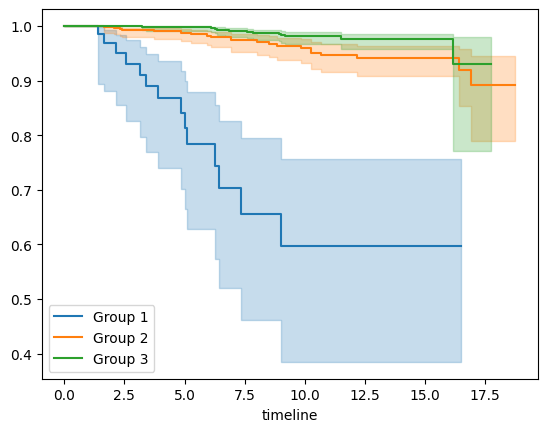

In [75]:
#KM curve
from lifelines import KaplanMeierFitter
group1=data[data['lni']==1]
group2=data[data['lni']==0]
group3=data[data['lni']=='unknown']
T=group1['survival_years']
E=group1['cancer_specific_mortality']
T1=group2['survival_years']
E1=group2['cancer_specific_mortality']
T2=group3['survival_years']
E2=group3['cancer_specific_mortality']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1").plot_survival_function(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2").plot_survival_function(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3").plot_survival_function(ax=ax)